# Creating a TensorFlow.js Model for UI Image Classification

This tutorial demonstrates how to classify images of UI elements such as buttons and checkboxes using a tf.keras.Sequential model and how to load data using tf.keras.utils.image_dataset_from_directory. It covers the following concepts:

- Efficiently loading a dataset off the disk.
- Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand the data
2. Build an input pipeline
3. Construct the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

Additionally, this notebook illustrates how to convert a saved model into a TensorFlow.js model for use in Figma.

This Colab notebook is based on the TensorFlow tutorial document available at [this link](https://www.tensorflow.org/tutorials/images/classification).

## Setup

Import TensorFlow and other necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.14.0
GPU is available


## Preparing Your Images

To ensure the best results from your model, it is crucial to prepare a robust dataset. Follow these steps to gather and organize your images:

1. **Collect Images:** Begin by collecting images of various UI components. These could be from actual projects, screen captures, or even extracted from Figma. Aim to gather at least dozens of images for each UI category (folder). The more images you have, the better your model will perform.

2. **Use Figma-Dummy-Gen:** If you're struggling to find enough images, consider using the [figma-dummy-gen](https://github.com/dusskapark/figma-dummy-gen) plugin. This tool can generate images for you, supplementing your existing collection.

3. **Organize Your Images:** Once you've gathered your images, place them in the `dataset/TF_Image_classification` folder. Your folder structure should look something like this:

```
TF_Image_classification
|__ UI_Category_1
    |______ image1.jpg
    |______ image2.jpg
    |______ ...
|__ UI_Category_2
    |______ image1.jpg
    |______ image2.jpg
    |______ ...
```

In [2]:
import os

# Define the root path and the origin path
root_path = os.path.expanduser('./dataset/')
origin_path = root_path + 'TF_Image_classification/' # folder that contains the dummy images
screenshot_path = root_path + 'screenshot/' # folder that contains the real images that captured from the UI or Figma projects 
ui_path = root_path + 'ui/' # final UI dataset folder 

# Print the root path and the origin path
print('Origin path:', origin_path)
print('Screenshot path:', screenshot_path)
print('UI path:', ui_path)


Origin path: ./dataset/TF_Image_classification/
Screenshot path: ./dataset/screenshot/
UI path: ./dataset/ui/



### Adjusting Dataset Images

The images in the dataset must be adjusted to match the input size of the model. For example, for MobileNetV3, the input size is 224x224x3, so the images in the dataset need to be adjusted to this size. The adjusted images are stored in the `ui_path` folder.


In [3]:
from PIL import Image

# Set the limit for the number of images per folder
LIMIT_IMAGES = 200  # Set to None for no limit

# Create the new directory if it doesn't exist
os.makedirs(ui_path, exist_ok=True)

# Get the list of all folders in the origin and screenshot paths
all_folders = set(os.listdir(origin_path) + os.listdir(screenshot_path))

# Loop through each folder in the list
for folder_name in all_folders:
    # Construct the full path to the origin and screenshot folders
    origin_folder_path = os.path.join(origin_path, folder_name)
    screenshot_folder_path = os.path.join(screenshot_path, folder_name)

    # Check if the origin and screenshot folders exist
    origin_exists = os.path.isdir(origin_folder_path)
    screenshot_exists = os.path.isdir(screenshot_folder_path)

    # If neither folder exists, skip this folder
    if not origin_exists and not screenshot_exists:
        print(f"Folder {folder_name} does not exist in either the origin or screenshot path. Please check the data.")
        continue

    # Get the list of files in the origin and screenshot folders
    origin_files = os.listdir(origin_folder_path) if origin_exists else []
    screenshot_files = os.listdir(screenshot_folder_path) if screenshot_exists else []

    # If there is a limit and the number of screenshot files is greater than the limit
    if LIMIT_IMAGES is not None and len(screenshot_files) > LIMIT_IMAGES:
        print(f"Folder {folder_name} has more than {LIMIT_IMAGES} images. Please check the data.")
        continue

    # Calculate the number of files to select from the origin folder
    num_files_to_select = min(len(origin_files), LIMIT_IMAGES-len(screenshot_files)) if LIMIT_IMAGES is not None else len(origin_files)

    # Randomly select files from the origin folder
    selected_origin_files = np.random.choice(origin_files, size=num_files_to_select, replace=False).tolist() if num_files_to_select > 0 else []

    # Combine the screenshot and selected origin files
    combined_files = screenshot_files + selected_origin_files

    # Shuffle the combined files
    np.random.shuffle(combined_files)

    # Create the new folder if it doesn't exist
    new_folder_path = os.path.join(ui_path, folder_name)
    os.makedirs(new_folder_path, exist_ok=True)
    
    # Loop through each file in the combined files
    for filename in combined_files:
        # Only process .png files
        if filename.endswith('.png'):
            # Check if the file is from the screenshot or origin folder
            if filename in screenshot_files:
                folder_path = screenshot_folder_path
            else:
                folder_path = origin_folder_path

            # Construct the full path to the file
            file_path = os.path.join(folder_path, filename)
            
            # Open the image file
            img = Image.open(file_path).convert("RGBA")
            
            # Get the width and height of the image
            width, height = img.size
            
            # Create a new square image with alpha channel
            new_image = Image.new('RGBA', (max(width, height), max(width, height)))
            
            # Paste the original image into the center of the new image
            new_image.paste(img, (int((new_image.width - img.width) / 2), int((new_image.height - img.height) / 2)))
            
            # Create a white background image
            bg = Image.new('RGBA', new_image.size, (255, 255, 255, 255))  # RGBA mode
            
            # Combine the new image with the white background
            final_image = Image.alpha_composite(bg, new_image)
            
            # Resize the final image to the target size
            final_image = final_image.resize([224, 224], Image.LANCZOS)
            
            # Construct the new file path
            new_file_path = os.path.join(new_folder_path, filename)
            
            # Save the new image as PNG
            final_image.save(new_file_path, format='PNG')
            
            # Print the result
            print(f"Saved new image at {new_file_path}")

Saved new image at ./dataset/ui/Tabs/Tabs-dark - 2 - 112.png
Saved new image at ./dataset/ui/Tabs/Tabs - 5 - 15.png
Saved new image at ./dataset/ui/Tabs/Tabs - 9 - 09.png
Saved new image at ./dataset/ui/Tabs/21838_015.png
Saved new image at ./dataset/ui/Tabs/42122_012.png
Saved new image at ./dataset/ui/Tabs/1282_032.png
Saved new image at ./dataset/ui/Tabs/wf_180_037.png
Saved new image at ./dataset/ui/Tabs/Tabs-dark - 10 - 120.png
Saved new image at ./dataset/ui/Tabs/Tabs-dark - 5 - 105.png
Saved new image at ./dataset/ui/Tabs/36159_021.png
Saved new image at ./dataset/ui/Tabs/Tabs-dark - 2 - 102.png
Saved new image at ./dataset/ui/Tabs/13766_012.png
Saved new image at ./dataset/ui/Tabs/Tabs - 5 - 05.png
Saved new image at ./dataset/ui/Tabs/Tabs - 3 - 03.png
Saved new image at ./dataset/ui/Tabs/Tabs-dark - 1 - 111.png
Saved new image at ./dataset/ui/Tabs/1218_040.png
Saved new image at ./dataset/ui/Tabs/22379_011.png
Saved new image at ./dataset/ui/Tabs/Tabs-dark - 8 - 118.png
Saved 

You can use the following code to identify the names of each folder and the number of files in each folder. This will help you keep track of your dataset and ensure you have enough images for each category.

In [4]:
# Function to get the number of files in a directory
def get_num_files(path):
    return len([entry for entry in os.scandir(path) if entry.is_file()])

# Function to print the directory tree
def draw_folder_tree(path, level=0):
    expanded_path = os.path.expanduser(path)
    folders_files_count = {}

    for entry in os.scandir(expanded_path):
        if entry.is_dir():
            num_files = get_num_files(entry.path)
            folders_files_count[entry.name] = num_files

    sorted_folders_files_count = sorted(folders_files_count.items(), key=lambda item: item[0])

    for folder_name, files_count in sorted_folders_files_count:
        print(f"{'    '*level}|- {folder_name}/ ({files_count} files)")
        draw_folder_tree(os.path.join(path, folder_name), level+1)
        
# Draw the folder tree of the directory
print('dataset/ui:')
draw_folder_tree(ui_path)

dataset/ui:
|- Bottom app bars/ (32 files)
|- Bottom sheets/ (16 files)
|- Cards/ (192 files)
|- Checkboxes/ (182 files)
|- Chips/ (200 files)
|- Date picker/ (32 files)
|- FABs/ (200 files)
|- Menu/ (36 files)
|- Menu List/ (200 files)
|- Navigation bars/ (44 files)
|- Navigation rails/ (24 files)
|- Progress indicators/ (40 files)
|- Search/ (128 files)
|- Segmented buttons/ (64 files)
|- Side sheets/ (32 files)
|- Sliders/ (199 files)
|- Tabs/ (69 files)
|- Time picker/ (24 files)
|- Tooltips/ (8 files)


## Load data using a Keras utility

Next, load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 224
img_width = 224

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  ui_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1722 files belonging to 19 classes.
Using 1378 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  ui_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1722 files belonging to 19 classes.
Using 344 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [8]:
class_names = train_ds.class_names
print(class_names)

['Bottom app bars', 'Bottom sheets', 'Cards', 'Checkboxes', 'Chips', 'Date picker', 'FABs', 'Menu', 'Menu List', 'Navigation bars', 'Navigation rails', 'Progress indicators', 'Search', 'Segmented buttons', 'Side sheets', 'Sliders', 'Tabs', 'Time picker', 'Tooltips']


## Visualize the data

Here are the first nine images from the training dataset:

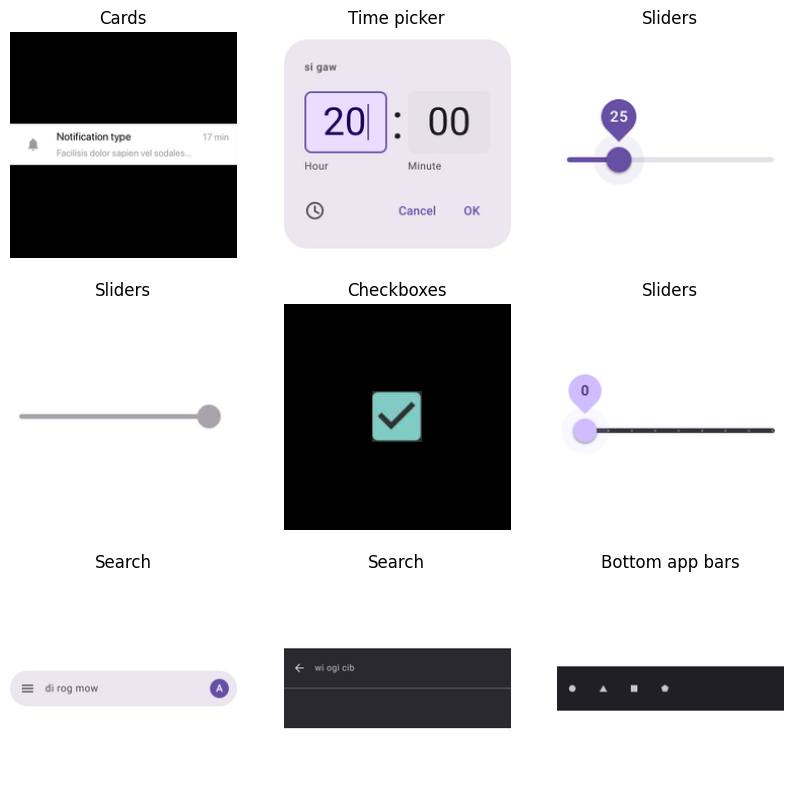

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


The image_batch is a tensor of the shape (32, 224, 224, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch`overlaps data preprocessing and model execution while training.



In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [12]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8705883


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

> Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

### Train the model

Train the model for 5 epochs with the Keras `Model.fit` method:

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 10

# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=2,  # Stop training when validation loss has not improved for 2 epochs
    verbose=1  # Log the result
)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]  # Add the EarlyStopping callback
)

Epoch 1/10
44/44 [==============================] - 3s 51ms/step - loss: 2.2653 - accuracy: 0.3730 - val_loss: 1.1906 - val_accuracy: 0.6948
Epoch 2/10
44/44 [==============================] - 2s 41ms/step - loss: 0.8263 - accuracy: 0.7794 - val_loss: 0.8088 - val_accuracy: 0.7587
Epoch 3/10
44/44 [==============================] - 2s 39ms/step - loss: 0.5198 - accuracy: 0.8440 - val_loss: 0.4630 - val_accuracy: 0.8924
Epoch 4/10
44/44 [==============================] - 2s 39ms/step - loss: 0.6459 - accuracy: 0.8360 - val_loss: 0.7778 - val_accuracy: 0.8227
Epoch 5/10
44/44 [==============================] - 2s 41ms/step - loss: 0.4149 - accuracy: 0.8999 - val_loss: 0.6241 - val_accuracy: 0.8605
Epoch 5: early stopping


## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

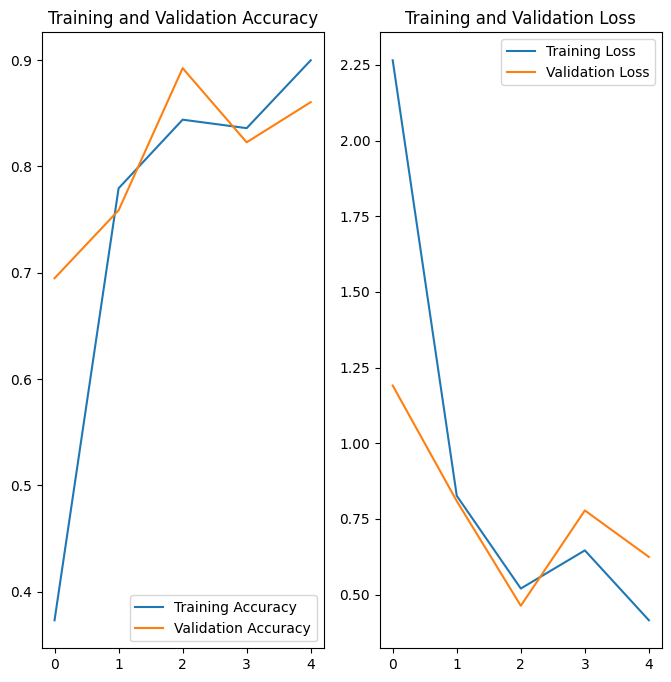

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # Change this line

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

In [19]:
model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 28, 28, 64)       

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 10

# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=2,  # Stop training when validation loss has not improved for 2 epochs
    verbose=1  # Log the result
)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]  # Add the EarlyStopping callback
)

Epoch 1/10
44/44 [==============================] - 3s 50ms/step - loss: 220.4400 - accuracy: 0.3411 - val_loss: 2.1809 - val_accuracy: 0.4942
Epoch 2/10
44/44 [==============================] - 2s 44ms/step - loss: 1.3181 - accuracy: 0.6807 - val_loss: 1.3007 - val_accuracy: 0.7849
Epoch 3/10
44/44 [==============================] - 2s 44ms/step - loss: 0.8538 - accuracy: 0.8179 - val_loss: 1.2410 - val_accuracy: 0.7762
Epoch 4/10
44/44 [==============================] - 2s 41ms/step - loss: 0.9534 - accuracy: 0.8316 - val_loss: 2.1558 - val_accuracy: 0.5087
Epoch 5/10
44/44 [==============================] - 2s 40ms/step - loss: 1.2211 - accuracy: 0.7090 - val_loss: 2.0612 - val_accuracy: 0.7413
Epoch 5: early stopping


## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

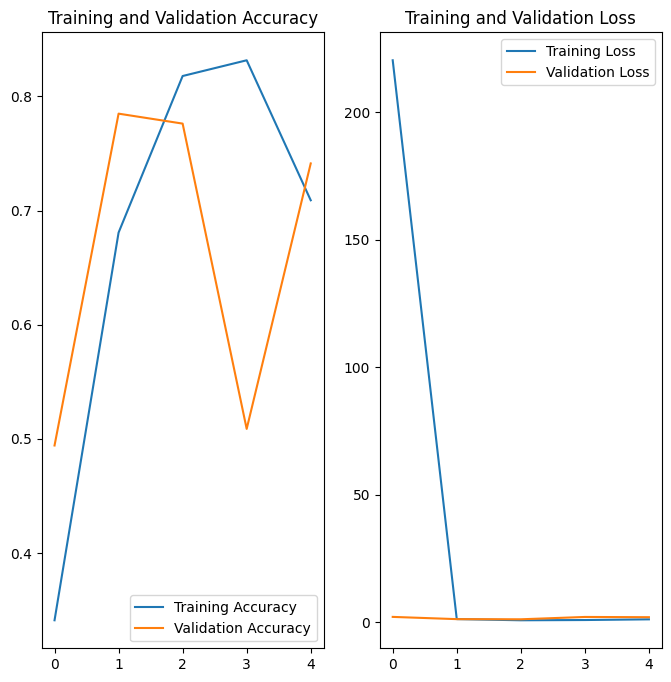

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # Change this line

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

> Note: Data augmentation and dropout layers are inactive at inference time.

1/1 [==============================] - 0s 75ms/step


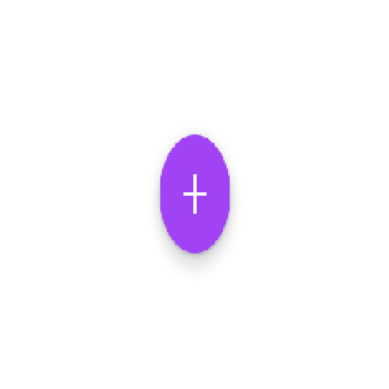

This image most likely belongs to Tabs with a 93.85 percent confidence.


In [24]:
button_url = "https://lh3.googleusercontent.com/3LGl6q_PNG1k8hRSxreK6ut8ay1MVDl8Bg88WvJcuhnnY77sJE_N4_2fOz7t35T8fZQOtrht4gV2rrFzlUmH3Yc1UnWwrRXHdf4p6V9qOcF6ig=s0"

button_path = tf.keras.utils.get_file('fab', origin=button_url)

img = tf.keras.utils.load_img(
    button_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# print the button image
plt.imshow(img)
plt.axis('off')
plt.show()

print(
    
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

## Convert to TensorFlow.js

Now that you've trained your model, you can convert it to TensorFlow.js format for use in Figma. This will allow you to classify UI elements directly in Figma.

In [25]:
# Save the trained model inside {root_path}
model.save(f'{root_path}keras_model.h5')

# convert the tf_saved_model to tfjs model via tensorflowjs_converter
!tensorflowjs_converter --input_format=keras {root_path}keras_model.h5 {root_path}tfjs_model/


/Users/jude.park/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
import os
import json

# Function to convert name to URL
def name_to_url(name):
    # Convert to lower case and replace spaces with hyphens
    url_name = name.lower().replace(" ", "-")
    # Construct the URL
    url = f"{base_url}/{url_name}"
    return url

# Set the base URL
base_url = "https://m3.material.io/components"

# List all folders in ui_path
folder_names = [entry.name for entry in os.scandir(ui_path) if entry.is_dir()]

# Generate labels list
labels = [{"name": name, "url": name_to_url(name), "id": i+1} for i, name in enumerate(sorted(folder_names))]

print(labels)

# Write to metadata.json under the tfjs_model_path
with open(os.path.join(root_path, "tfjs_model/metadata.json"), "w") as f:
    json.dump({"labels": labels}, f)


[{'name': 'Bottom app bars', 'url': 'https://m3.material.io/components/bottom-app-bars', 'id': 1}, {'name': 'Bottom sheets', 'url': 'https://m3.material.io/components/bottom-sheets', 'id': 2}, {'name': 'Cards', 'url': 'https://m3.material.io/components/cards', 'id': 3}, {'name': 'Checkboxes', 'url': 'https://m3.material.io/components/checkboxes', 'id': 4}, {'name': 'Chips', 'url': 'https://m3.material.io/components/chips', 'id': 5}, {'name': 'Date picker', 'url': 'https://m3.material.io/components/date-picker', 'id': 6}, {'name': 'FABs', 'url': 'https://m3.material.io/components/fabs', 'id': 7}, {'name': 'Menu', 'url': 'https://m3.material.io/components/menu', 'id': 8}, {'name': 'Menu List', 'url': 'https://m3.material.io/components/menu-list', 'id': 9}, {'name': 'Navigation bars', 'url': 'https://m3.material.io/components/navigation-bars', 'id': 10}, {'name': 'Navigation rails', 'url': 'https://m3.material.io/components/navigation-rails', 'id': 11}, {'name': 'Progress indicators', 'ur